In [60]:
__author__ = 'ORI'

from matplotlib.collections import LineCollection

import numpy as np
import scipy.io
import sys, os
import matplotlib.pyplot as plt
# I should learn how to load libraries in a more elegant way



sys.path.append(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\OriKerasExtension')
#import OriKerasExtension
import ThesisHelper
#reload(OriKerasExtension)
reload(ThesisHelper)
from   ThesisHelper import LoadSingleSubjectPython, readCompleteMatFile, ExtractDataVer4
import P300Prediction
reload(P300Prediction)
from P300Prediction import accuracy_by_repetition, create_target_table


sys.path.append(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\OriKerasExtension')
#import OriKerasExtension
import ThesisHelper
from sklearn.metrics import roc_curve, auc, roc_auc_score
import P300Prediction
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from scipy import stats
from sklearn.cross_validation import StratifiedShuffleSplit

#reload(OriKerasExtension)
reload(ThesisHelper)
from ThesisHelper import LoadSingleSubjectPython, readCompleteMatFile, ExtractDataVer4
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

reload(P300Prediction)
from P300Prediction import accuracy_by_repetition, create_target_table


# [all_target, all_non_target] = LoadSingleSubjectPython(r'C:\Users\ORI\Documents\Thesis\dataset_all\RSVP_Color116msVPfat.mat')



# all_samples = np.vstack((all_target,all_non_target))


# '''
# Create the tagging column
# '''
# all_tags = np.vstack((np.ones((all_target.shape[0],1)), np.zeros((all_non_target.shape[0],1))))



# from OriKerasExtension.OriKerasExtension import DebugLSTM
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from  keras.regularizers import WeightRegularizer

'''
define the neural network model:
'''


def create_compile_cnn_model():
    model = Sequential()

    number_of_time_stamps = 20
    number_of_out_channels = 10
    number_of_in_channels = 55
    length_of_time_axe_mask = 10

    model.add(Convolution2D(nb_filter=10,
                            nb_col=number_of_out_channels,
                            nb_row=1,
                            input_shape=(1, number_of_time_stamps, number_of_in_channels),
                            border_mode='same',
                            init='glorot_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, number_of_in_channels)))
    model.add(
        Convolution2D(nb_filter=number_of_out_channels, nb_row=6, nb_col=1, border_mode='same', init='glorot_normal'))
    model.add(MaxPooling2D(pool_size=(20, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd')
    return model

def create_compile_lstm_model():

    '''
    define the neural network model:
    '''
    model_lstm = Sequential()

    model_lstm.add(LSTM(input_dim=55, output_dim=20,return_sequences=True))
    model_lstm.add(Dropout(0.3))
    model_lstm.add(LSTM(input_dim=20, output_dim=20,return_sequences=False))
    model_lstm.add(Dense(2, W_regularizer=l2(0.06)))
    model_lstm.add(Activation('softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model_lstm


def create_compile_dense_model():

    '''
    define the neural network model:
    '''
    model_lstm = Sequential()
    model_lstm.add(keras.layers.core.Flatten(input_shape=(55,100)))
    model_lstm.add(Dense(input_dim=55*100, output_dim=20 , W_regularizer=l2(0.06)))
    model_lstm.add(Activation('tanh'))
    model_lstm.add(Dense(2))
    model_lstm.add(Activation('softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model_lstm

# def down_sample_data()


def create_evaluation_data(gcd_res, down_samples_param):
#     gcd_res = readCompleteMatFile(file_name)
    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'], gcd_res['target'],
                                    -200, 800)
    # print  data_for_eval

    temp_data_for_eval = downsample_data(data_for_eval[0], data_for_eval[0].shape[1], down_samples_param)

    test_data_gcd, test_target_gcd = temp_data_for_eval[gcd_res['train_mode'] != 1], data_for_eval[1][
        gcd_res['train_mode'] != 1]
    return test_data_gcd, test_target_gcd


def downsample_data(data, number_of_original_samples, down_samples_param):


    new_number_of_time_stamps = number_of_original_samples / down_samples_param


    # print  data_for_eval
    temp_data_for_eval = np.zeros((data.shape[0], new_number_of_time_stamps, data.shape[2]))

    for new_i, i in enumerate(range(0, number_of_original_samples, down_samples_param)):
        temp_data_for_eval[:, new_i, :] = np.mean(data[:, range(i, (i + down_samples_param)), :], axis=1)
    return temp_data_for_eval


def create_train_data(gcd_res, down_samples_param):
    all_positive_train = []
    all_negative_train = []

#     others = ["RSVP_Color116msVPgcd.mat"]


#     for other_file_name in others:
#         file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(other_file_name)
#     gcd_res = readCompleteMatFile(file_name)
    last_time_stamp = 800
    fist_time_stamp = -200


    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'],
                                    gcd_res['target'], fist_time_stamp, last_time_stamp)

    # total_time = last_time_stamp - fist_time_stamp
    # number_of_original_samples = total_time / 5
    # new_number_of_time_stamps = number_of_original_samples / down_samples_param
    #
    #
    # # print  data_for_eval
    # temp_data_for_eval = np.zeros((data_for_eval[0].shape[0], new_number_of_time_stamps, data_for_eval[0].shape[2]))
    #
    # for new_i, i in enumerate(range(0, 200, new_number_of_time_stamps)):
    #     temp_data_for_eval[:, new_i, :] = np.mean(data_for_eval[0][:, range(i, (i + new_number_of_time_stamps)), :], axis=1)
    print data_for_eval[0].shape
    temp_data_for_eval = downsample_data(data_for_eval[0],data_for_eval[0].shape[1], down_samples_param)

    positive_train_data_gcd = temp_data_for_eval[
        np.all([gcd_res['train_mode'] == 1, gcd_res['target'] == 1], axis=0)]
    negative_train_data_gcd = temp_data_for_eval[
        np.all([gcd_res['train_mode'] == 1, gcd_res['target'] == 0], axis=0)]
    all_positive_train.append(positive_train_data_gcd)
    all_negative_train.append(negative_train_data_gcd)

    positive_train_data_gcd = np.vstack(all_positive_train)
    negative_train_data_gcd = np.vstack(all_negative_train)

    all_data = np.vstack([positive_train_data_gcd, negative_train_data_gcd])

    all_tags = np.vstack(
        [np.ones((positive_train_data_gcd.shape[0], 1)), np.zeros((negative_train_data_gcd.shape[0], 1))])
    categorical_tags = to_categorical(all_tags)

    shuffeled_samples, suffule_tags = shuffle(all_data, categorical_tags, random_state=0)
    # shuffeled_samples, suffule_tags = (all_data, categorical_tags)
    return shuffeled_samples, suffule_tags


def create_data_for_compare_by_repetition(file_name):
    gcd_res = readCompleteMatFile(file_name)
    sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
                       train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
                       stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])
    return sub_gcd_res

#shuffeled_samples, suffule_tags = create_train_data(file_name=None, down_samples_param=5)
# shuffeled_samples, suffule_tags = create_train_data(file_name=None, down_samples_param=20)
model = create_compile_lstm_model()
original_weights = model.get_weights()

# data_set_locations = ["RSVP_Color116msVPicr.mat",
#                       "RSVP_Color116msVPpia.mat",
#                       "RSVP_Color116msVPfat.mat",
#                       "RSVP_Color116msVPgcb.mat",
#                       "RSVP_Color116msVPgcc.mat",
#                       "RSVP_Color116msVPgcd.mat",
#                       "RSVP_Color116msVPgcf.mat",
#                       "RSVP_Color116msVPgcg.mat",
#                       "RSVP_Color116msVPgch.mat",
#                       "RSVP_Color116msVPiay.mat",
#                       "RSVP_Color116msVPicn.mat"];

data_set_locations = ["RSVP_Color116msVPgcd.mat"]

results = []

for subject_name in data_set_locations:
    file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
    gcd_res = readCompleteMatFile(file_name)



DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10240-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpzaucyl/e5654ed977c7ce6c724ba9233be55d88.lib and object c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10240-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpzaucyl/e5654ed977c7ce6c724ba9233be55d88.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10240-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmphhv8ij/feba001387297c762217dcfc251c11ef.lib and object c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10240-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmphhv8ij/feba001387297c762217dcfc251c11ef.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10240-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmp6v6p7z/318f69f9e78730b0e39cb43fa74859c3.lib and object c:/tmp/thean

In [61]:
for i in range(1):
    model.set_weights(original_weights)
    down_sample_param = 2
    shuffeled_samples, suffule_tags = create_train_data(gcd_res, down_samples_param=down_sample_param)
    print shuffeled_samples.shape

    sss = list(StratifiedShuffleSplit(suffule_tags[:, 0], n_iter=1, test_size=0.1))
    checkpointer = ModelCheckpoint(filepath=r"c:\temp\25_dec_lstm_with_ds.hdf5", verbose=1, save_best_only=True)
    print shuffeled_samples[sss[0][0]].shape
    print stats.zscore(shuffeled_samples[sss[0][0]], axis=1).shape
    model.fit(stats.zscore(shuffeled_samples[sss[0][0]], axis=1), suffule_tags[sss[0][0]],
              nb_epoch=20, show_accuracy=True, verbose=1, validation_data=(
        stats.zscore(shuffeled_samples[sss[0][1]], axis=1), suffule_tags[sss[0][1]]),
              class_weight={0: 1, 1: 50},
              callbacks=[checkpointer])

    test_data_gcd, test_target_gcd = create_evaluation_data(gcd_res, down_samples_param=down_sample_param)

    test_prediction = model.predict(stats.zscore(test_data_gcd, axis=1), verbose=1)

    x, y, _ = roc_curve(test_target_gcd, test_prediction[:, 1])



    # This is the ROC curve
    # plt.plot(x, y)
    # plt.show()
    auc_score = roc_auc_score(test_target_gcd, test_prediction[:, 1])
    print "auc_score:{0}".format(auc_score)
    sub_gcd_res = create_data_for_compare_by_repetition(file_name)
    # sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
    # train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
    # stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])

    _, _, gt_data_for_sum = create_target_table(sub_gcd_res, test_target_gcd)
    _, _, actual_data_for_sum = create_target_table(sub_gcd_res, test_prediction[:, 1])

    print "accuracy_by_repetition {0}".format(
        accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))

results.append(dict(subject_name=subject_name, test_prediction=test_prediction, auc_score=auc_score))


(21000L, 200L, 55L)
(7200L, 100L, 55L)
(6480L, 100L, 55L)
(6480L, 100L, 55L)
Train on 6480 samples, validate on 720 samples
Epoch 1/20
6480/6480 [==============================] - 20s - loss: 0.9411 - acc: 0.9269 - val_loss: 0.1523 - val_acc: 0.9667
Epoch 00000: val_loss improved from inf to 0.15232, saving model to c:\temp\25_dec_lstm_with_ds.hdf5
Epoch 2/20
6480/6480 [==============================] - 19s - loss: 0.5933 - acc: 0.9667 - val_loss: 0.1460 - val_acc: 0.9667
Epoch 00001: val_loss improved from 0.15232 to 0.14596, saving model to c:\temp\25_dec_lstm_with_ds.hdf5
Epoch 3/20
6480/6480 [==============================] - 19s - loss: 0.5625 - acc: 0.9667 - val_loss: 0.1433 - val_acc: 0.9667
Epoch 00002: val_loss improved from 0.14596 to 0.14327, saving model to c:\temp\25_dec_lstm_with_ds.hdf5
Epoch 4/20
6480/6480 [==============================] - 19s - loss: 0.5133 - acc: 0.9667 - val_loss: 0.1410 - val_acc: 0.9667
Epoch 00003: val_loss improved from 0.14327 to 0.14103, savin

In [62]:
import keras


In [63]:
import theano
result_func = theano.function([model.get_input(train=False)], model.layers[-1].get_output(train=False)[:,0])
# convolutions = convout1_f(reshaped[img_to_visualize: img_to_visualize+1])

In [64]:
# result_func.grad
from theano import tensor as T
grad_func = T.grad(model.layers[-1].get_output(train=False)[0,0], model.get_input(train=False) )


In [65]:
result_func(stats.zscore(shuffeled_samples[sss[0][0]], axis=1).astype('float32')[0].reshape(1,100,55)).shape
# print stats.zscore(shuffeled_samples[sss[0][0]], axis=1).astype('float32')[0].reshape(1,40,55).shape

dlogistic = theano.function([model.get_input(train=False)], grad_func)



0.0166040062904
0


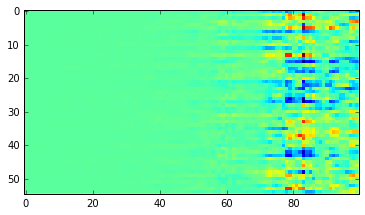

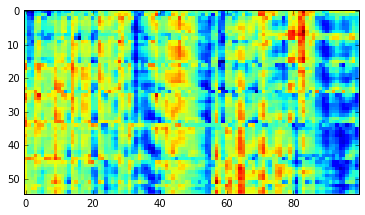

0.0111081087962
0


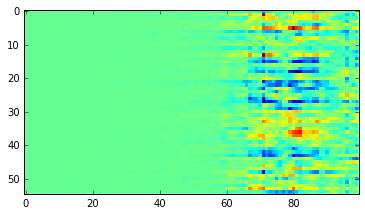

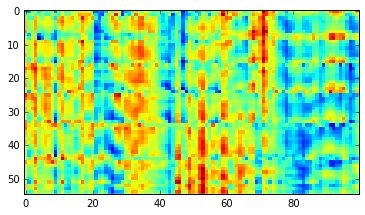

0.0111747961491
0


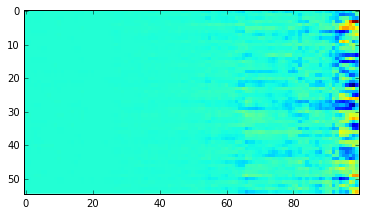

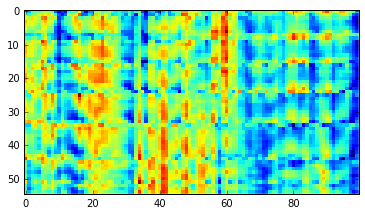

0.0105252759531
0


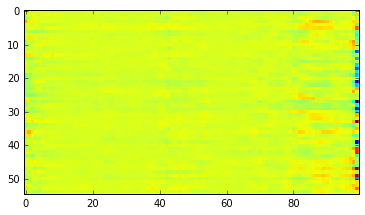

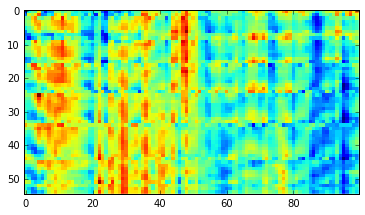

0.013560924679
1


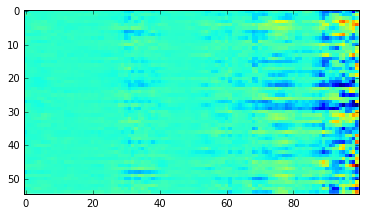

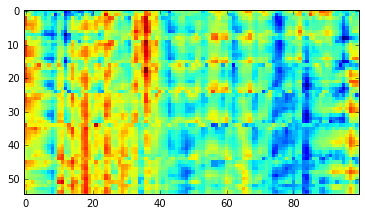

0.0244337357581
0


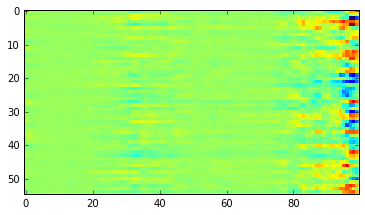

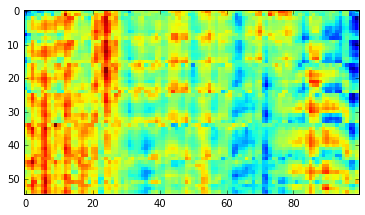

0.0114323468879
0


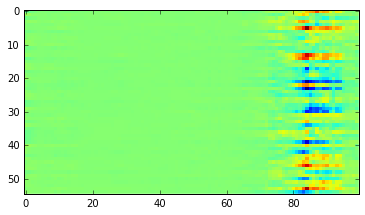

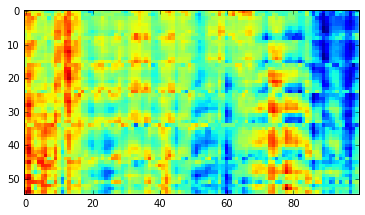

0.0104758944362
0


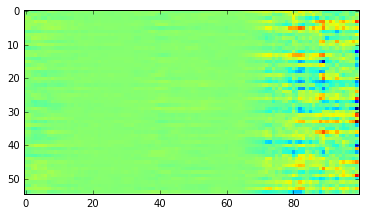

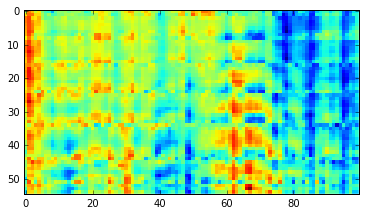

0.0100374510512
0


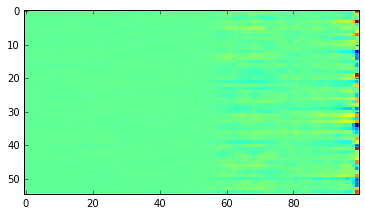

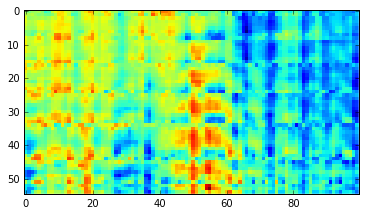

0.0102979773656
0


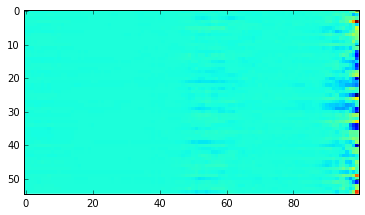

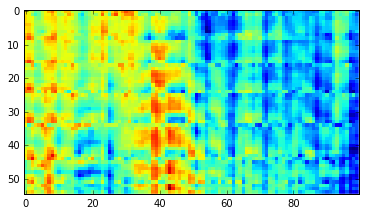

0.0109409028664
0


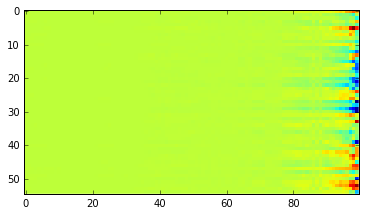

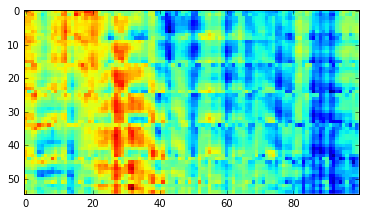

0.00982409343123
0


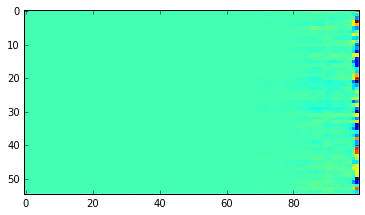

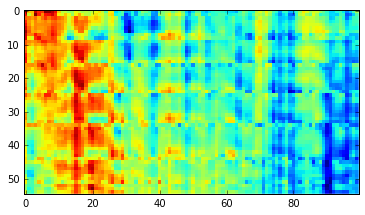

0.00976336747408
0


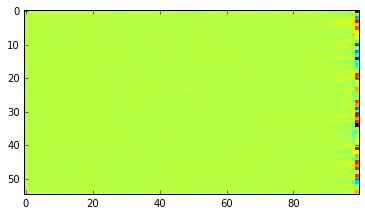

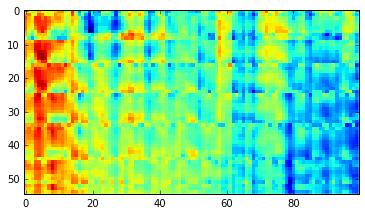

0.0107511254027
0


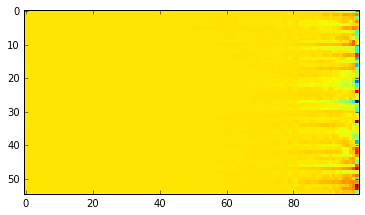

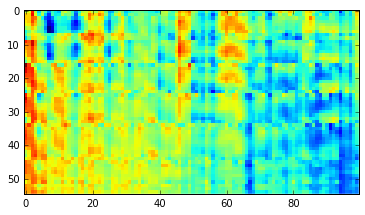

0.0110016679391
0


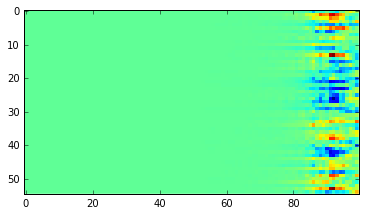

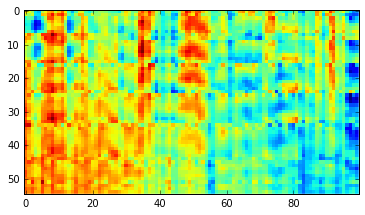

0.0101543460041
0


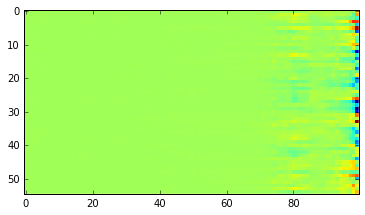

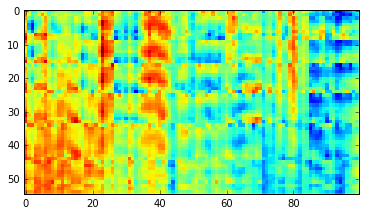

0.0104280179366
0


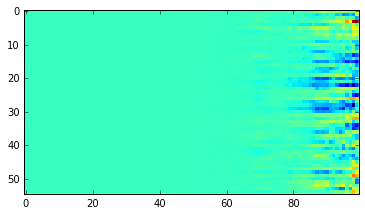

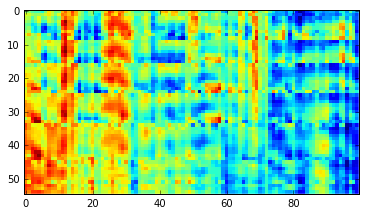

0.00986574683338
0


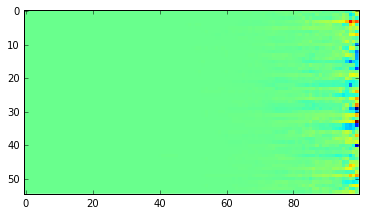

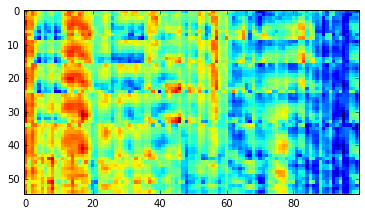

0.0100421430543
0


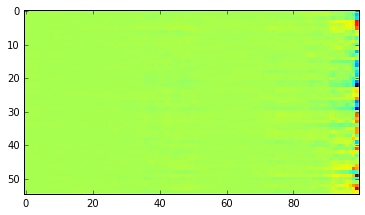

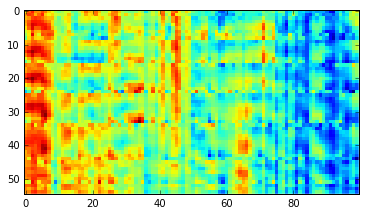

0.0154090765864
0


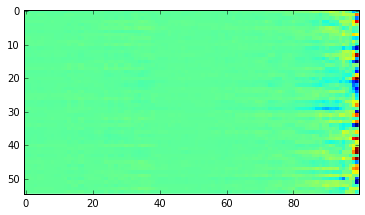

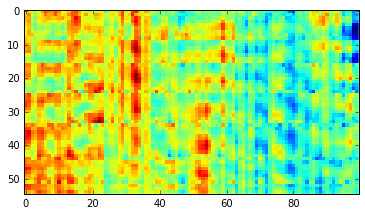

0.0671736523509
0


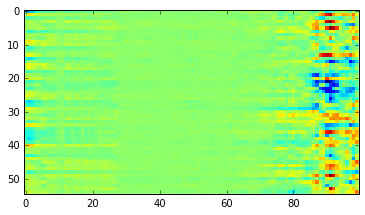

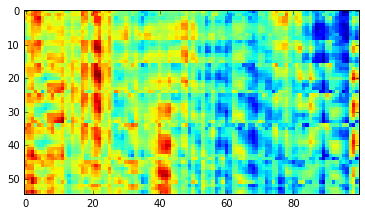

0.116732567549
0


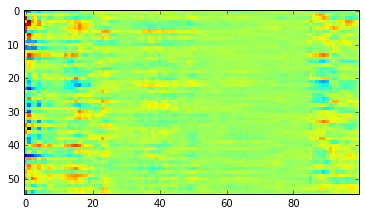

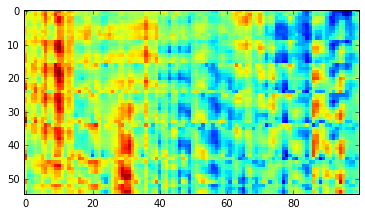

0.0152460439131
0


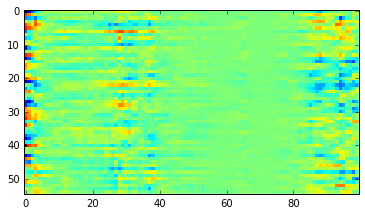

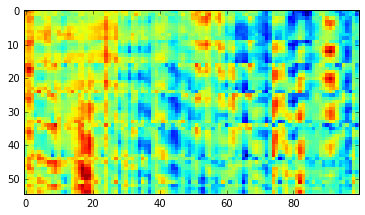

0.0127550316975
0


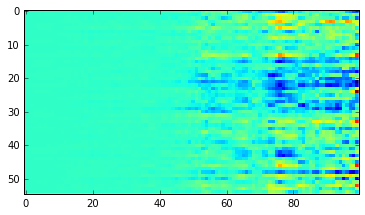

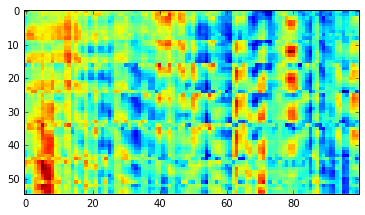

0.0115996683016
0


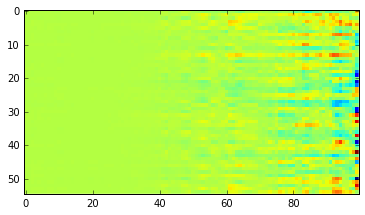

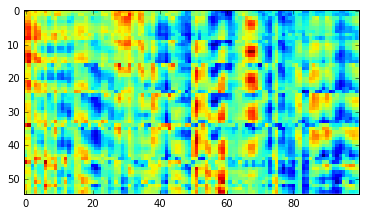

0.0107980258763
0


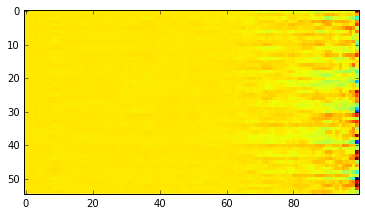

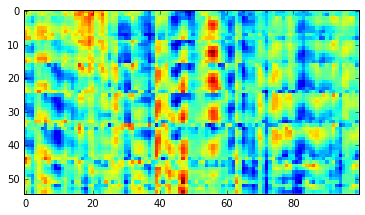

0.0114251272753
0


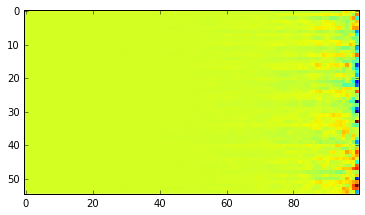

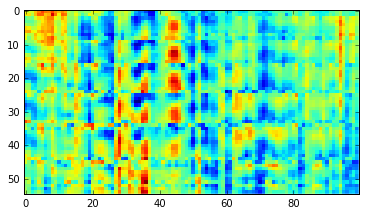

0.0115728229284
0


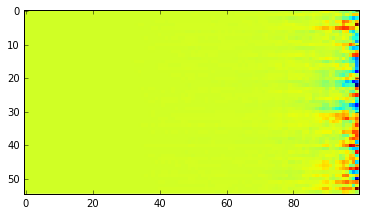

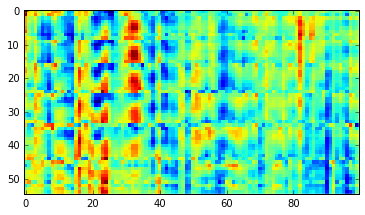

0.0106662297621
0


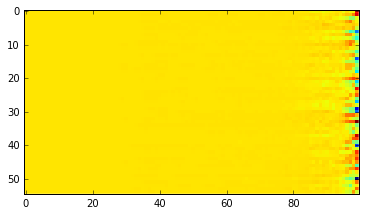

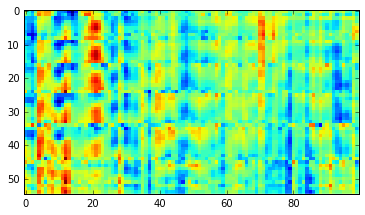

0.00995699129999
0


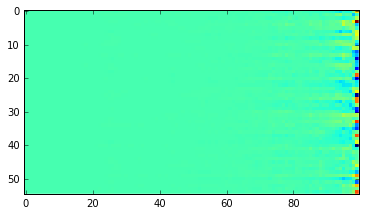

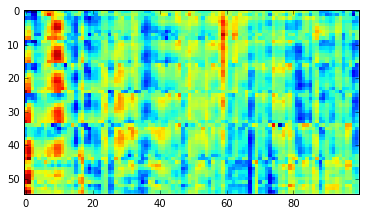

0.0110789081082
0


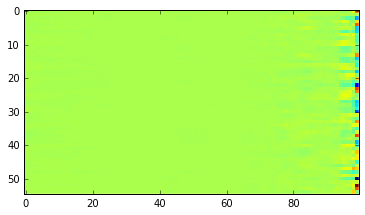

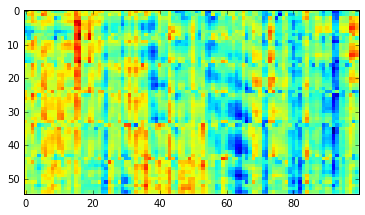

0.0107203852385
0


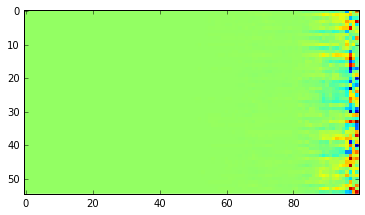

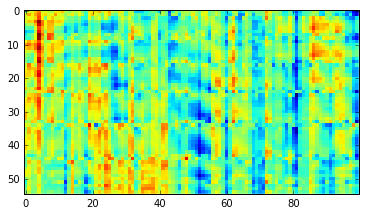

0.01203350164
0


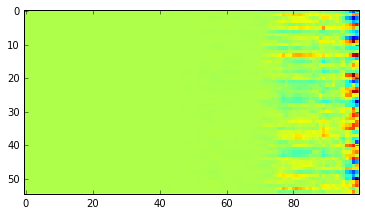

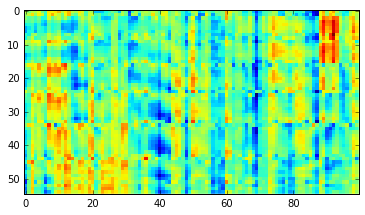

0.0104939918965
0


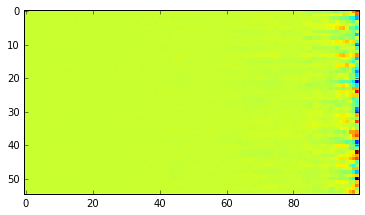

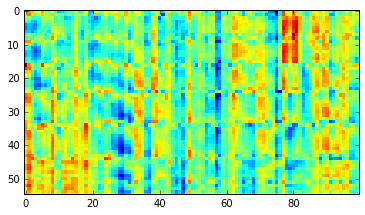

0.0129808718339
0


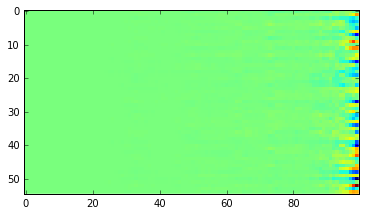

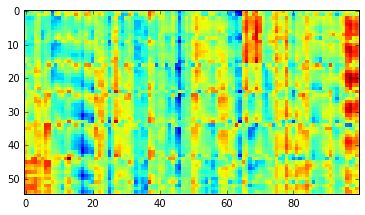

0.0265985168517
0


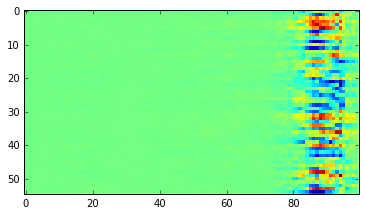

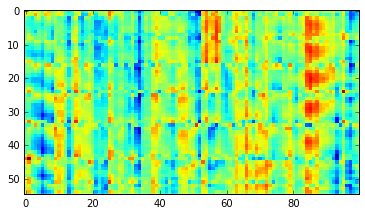

0.16242530942
0


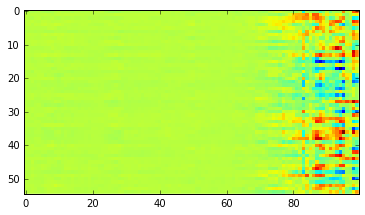

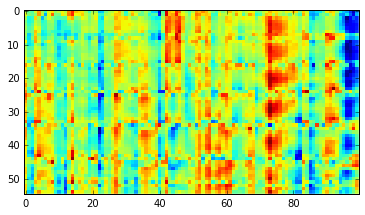

0.0520568117499
0


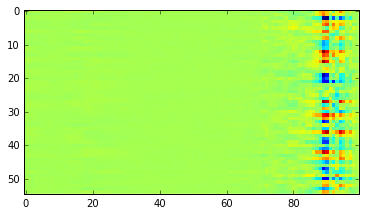

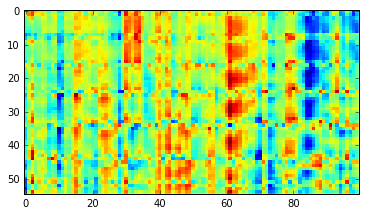

0.105495706201
0


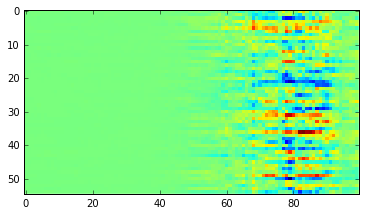

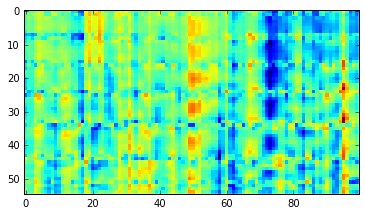

0.0151250241324
1


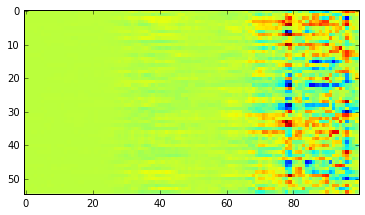

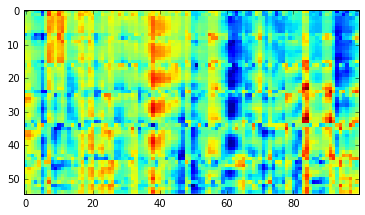

0.0115784816444
0


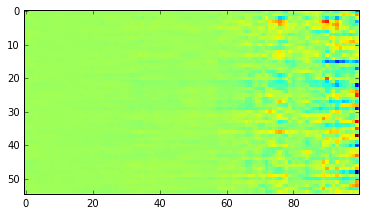

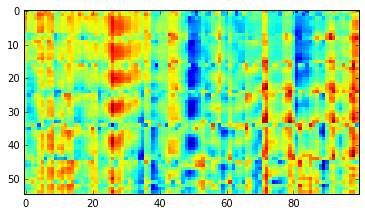

0.0110755702481
0


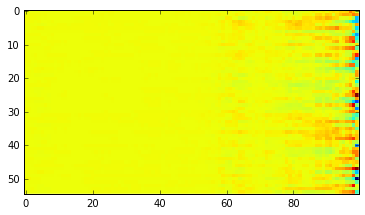

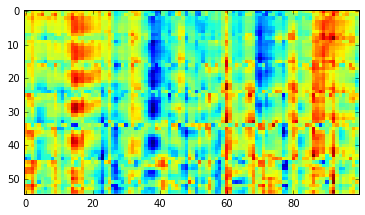

0.0109742553905
0


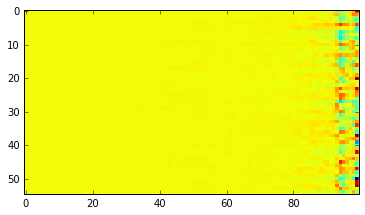

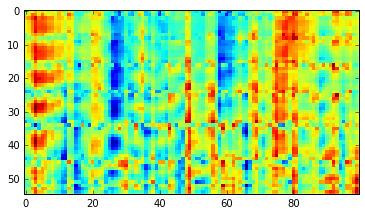

0.0104130106047
0


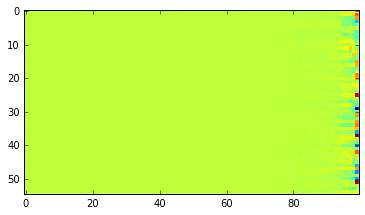

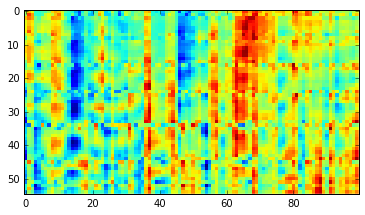

0.0111354943365
0


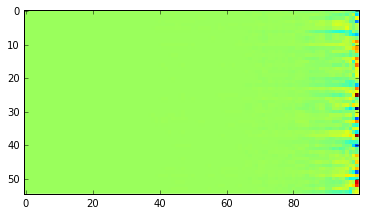

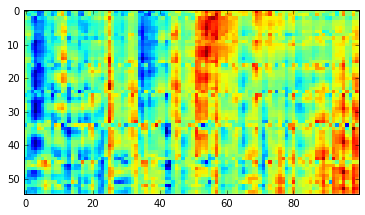

0.0121208829805
0


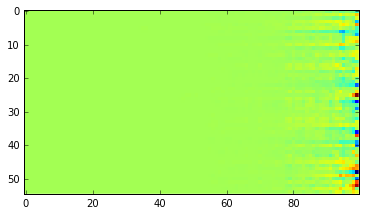

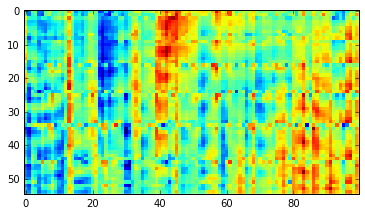

0.0166305825114
0


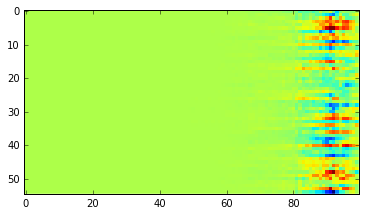

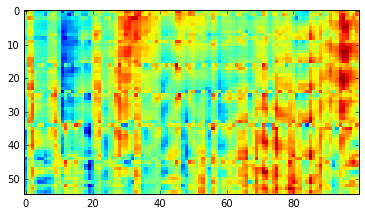

0.0317509025335
0


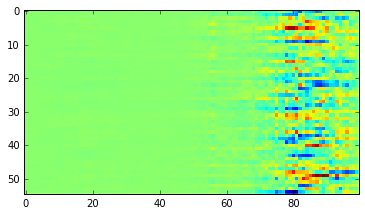

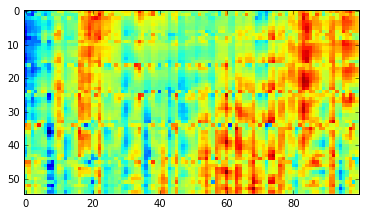

0.0119119528681
0


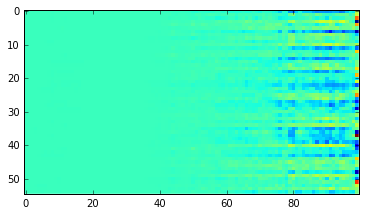

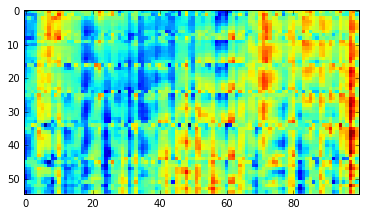

0.0168008580804
0


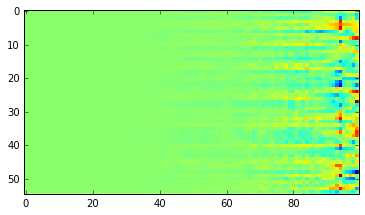

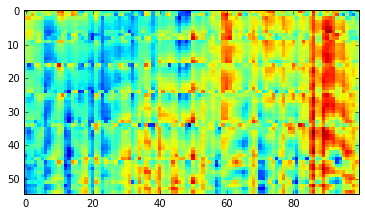

0.066308349371
0


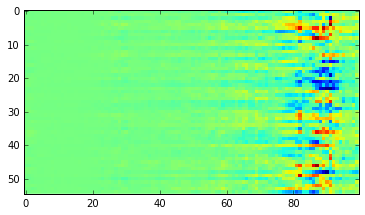

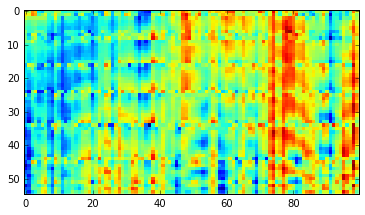

0.197784826159
0


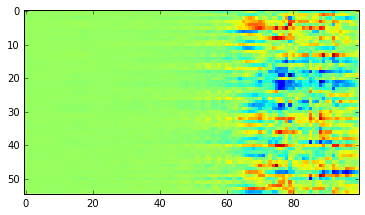

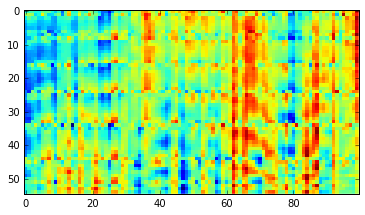

0.133793070912
0


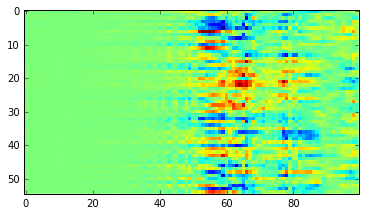

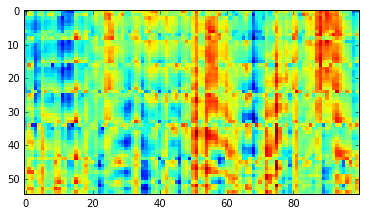

0.0146201616153
0


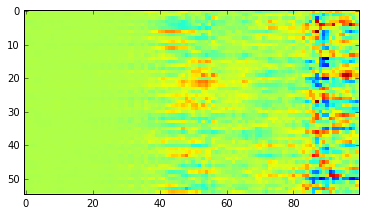

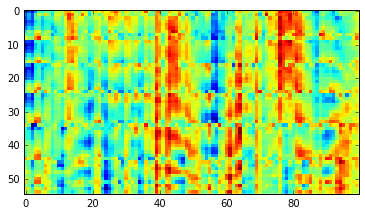

0.0102863097563
0


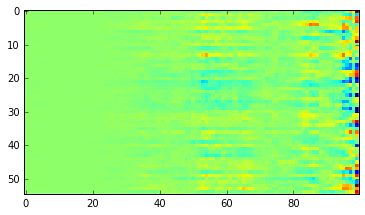

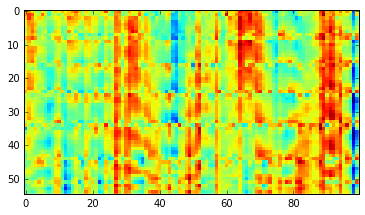

0.0101662119851
0


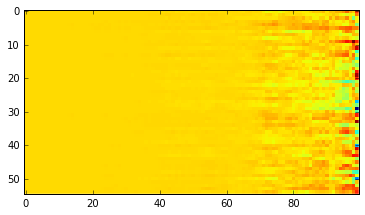

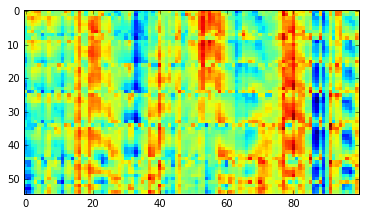

0.0111034885049
0


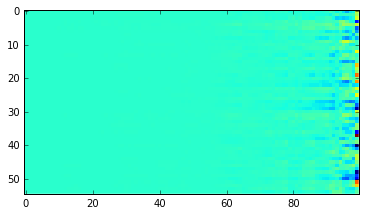

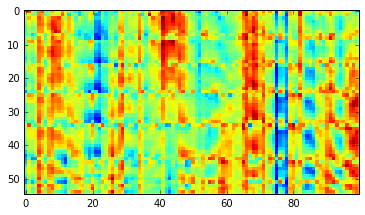

0.0106145851314
0


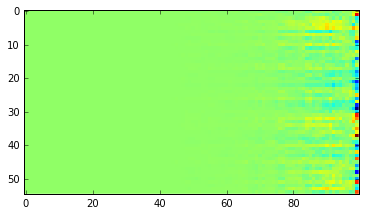

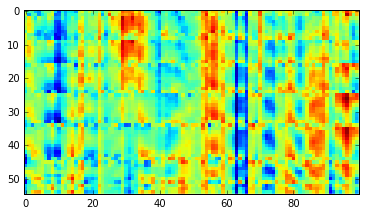

0.01969444938
0


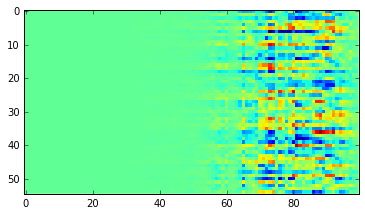

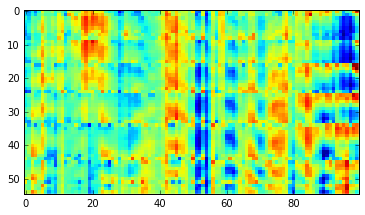

0.0975067317486
0


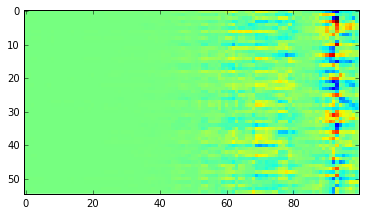

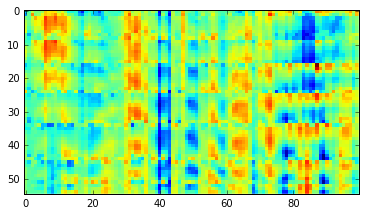

0.0111651569605
0


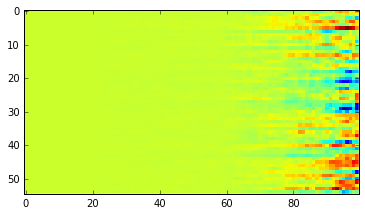

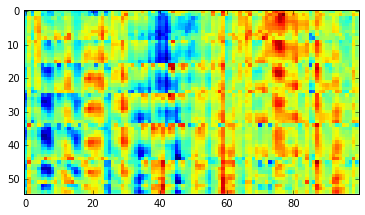

0.0123151727021
0


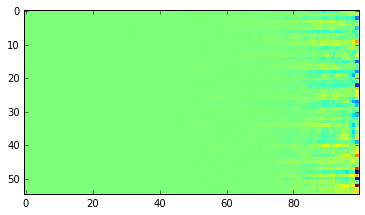

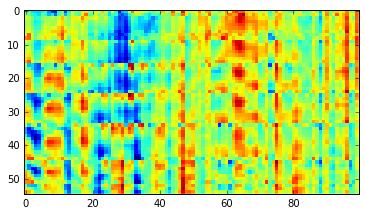

0.0125096822158
0


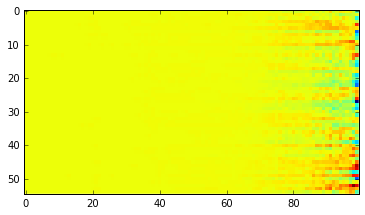

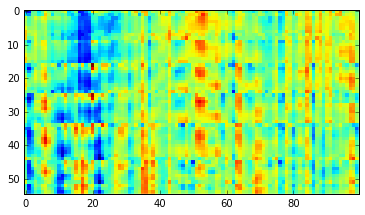

0.0118188718334
0


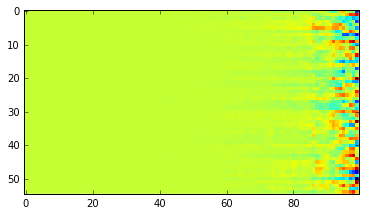

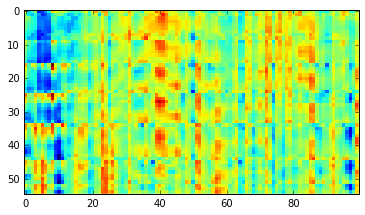

0.0126546323299
0


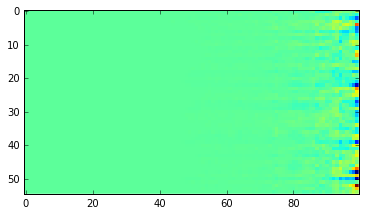

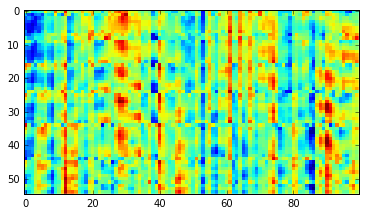

0.0106125669554
0


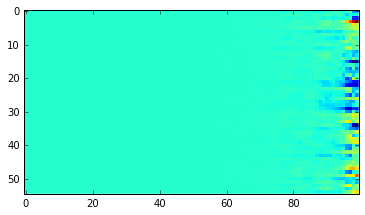

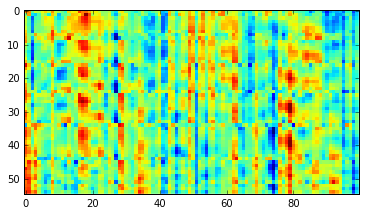

0.0110813230276
0


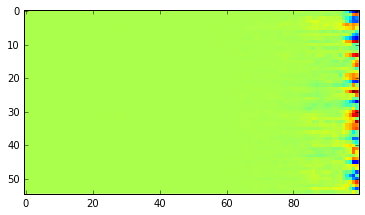

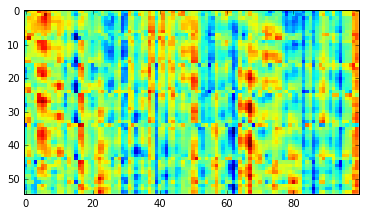

0.0122271524742
0


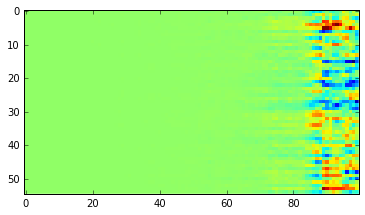

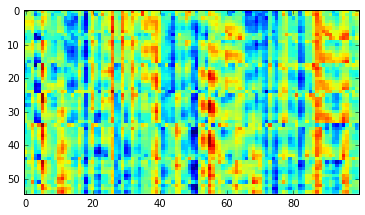

0.0106170801446
0


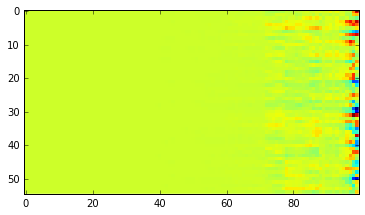

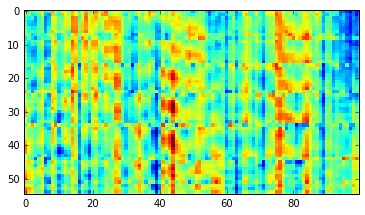

0.00990255922079
0


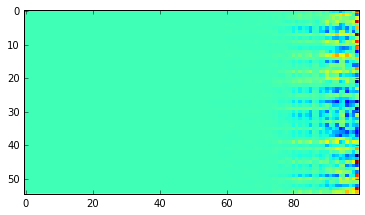

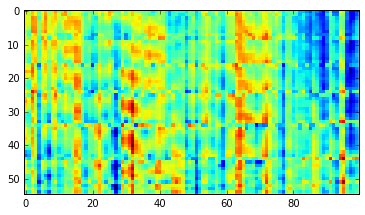

0.0100348731503
0


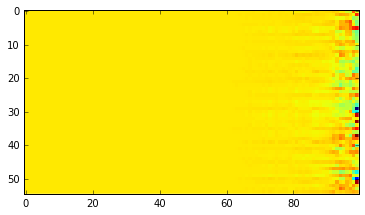

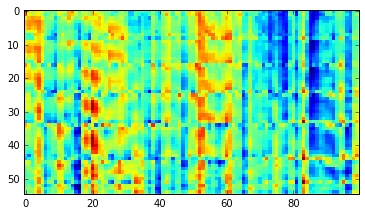

0.0104077160358
0


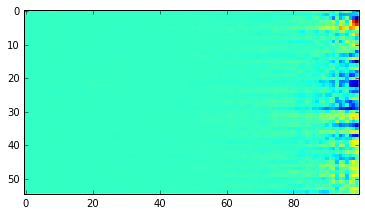

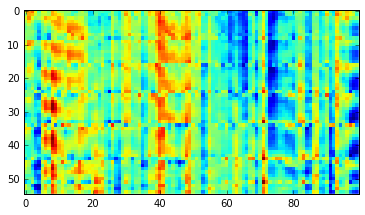

0.0126170692965
0


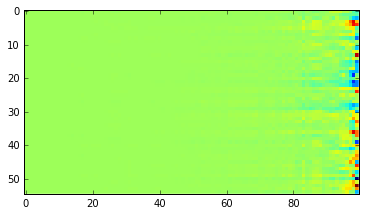

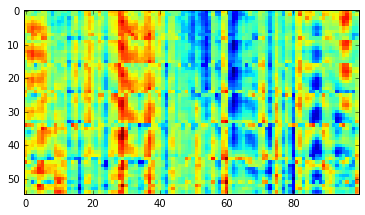

0.0340911857784
0


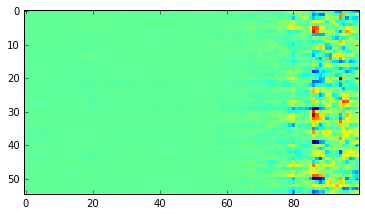

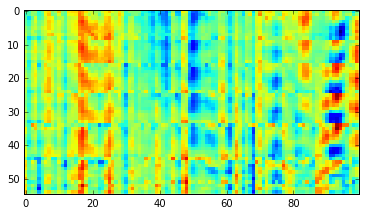

0.277886807919
1


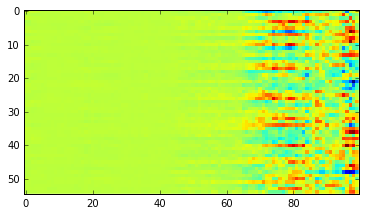

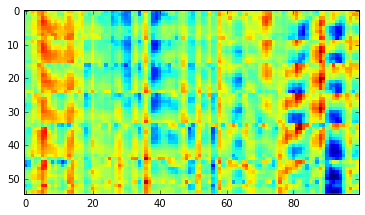

0.346447944641
0


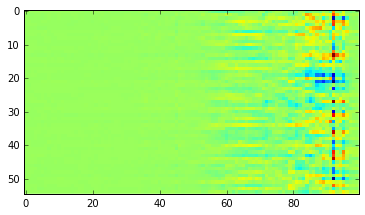

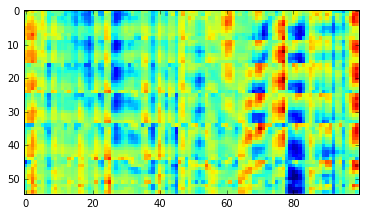

0.0195871591568
0


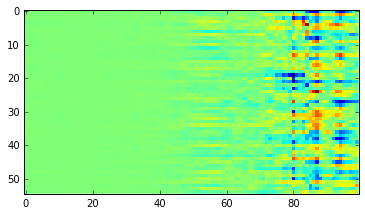

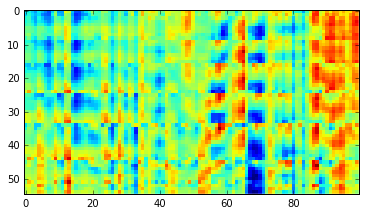

0.0136081809178
0


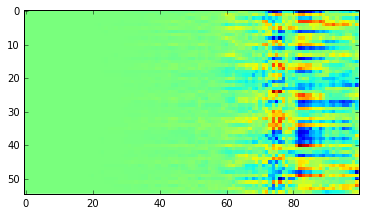

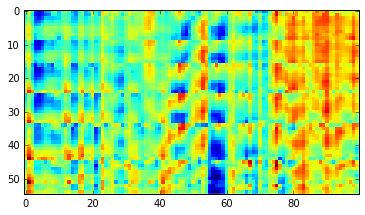

0.0109543781728
0


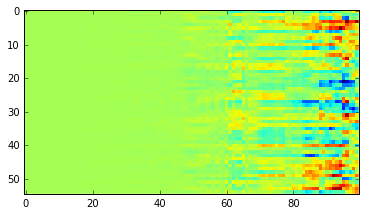

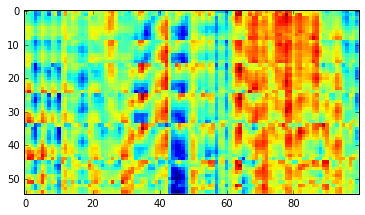

0.0109802493826
0


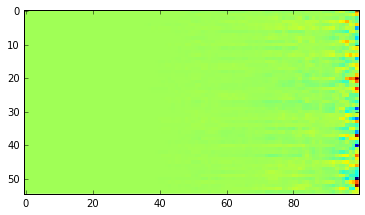

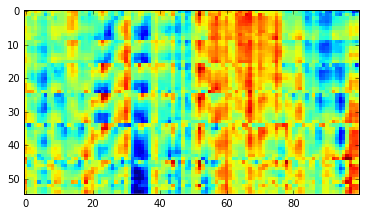

0.0102123795077
0


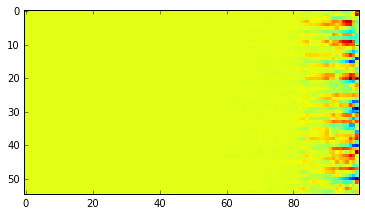

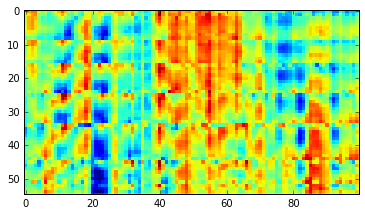

0.0114568453282
0


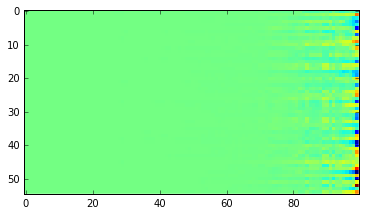

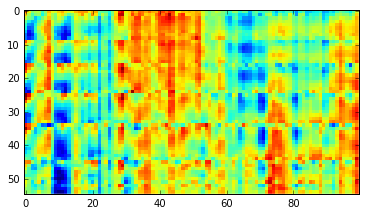

0.0109586473554
0


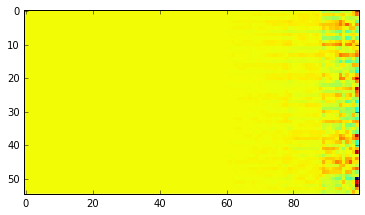

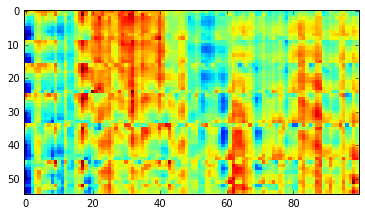

0.0118919536471
0


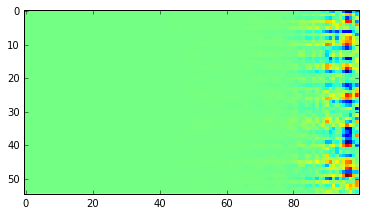

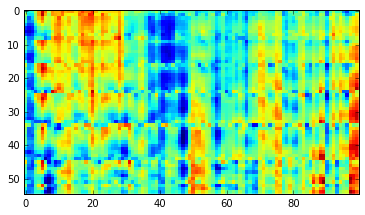

0.0106561947614
0


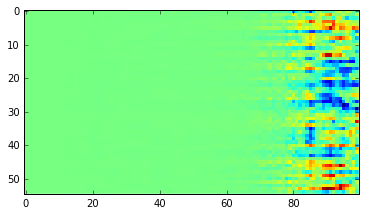

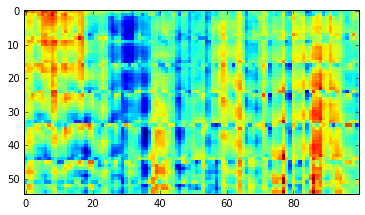

0.0100690843537
0


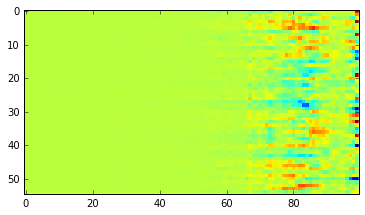

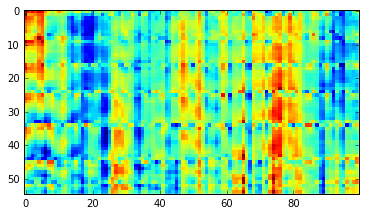

0.0102534005418
0


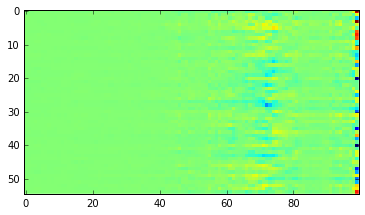

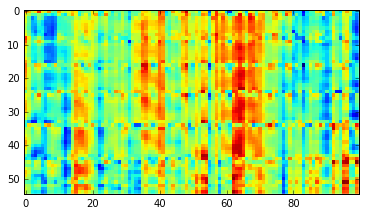

0.0166582036763
0


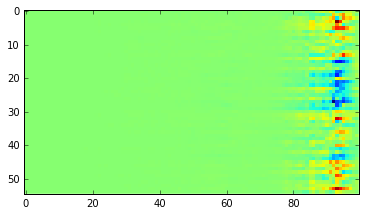

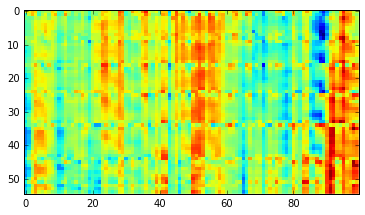

0.0117413355038
0


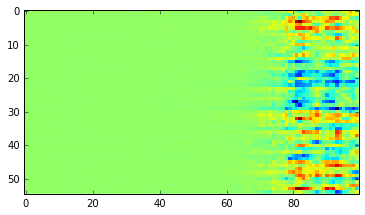

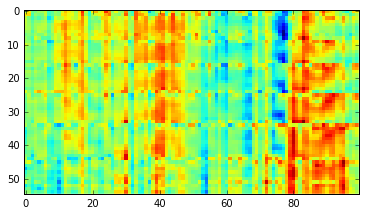

0.0103832567111
0


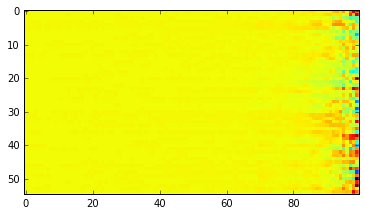

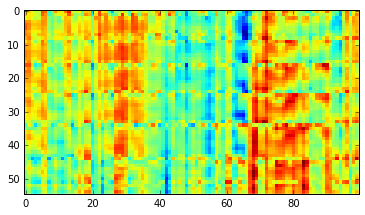

0.0123823974282
0


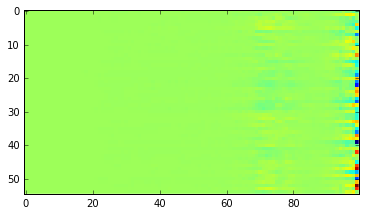

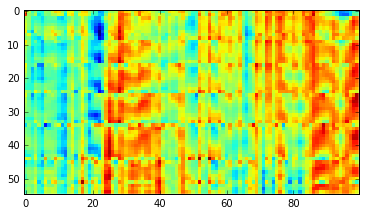

0.0116729121655
0


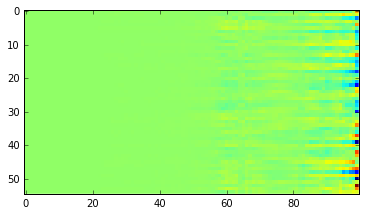

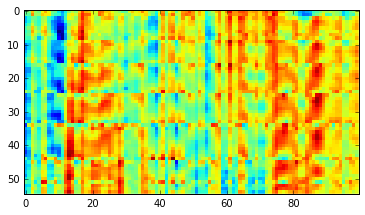

0.010280768387
0


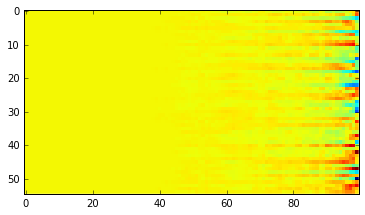

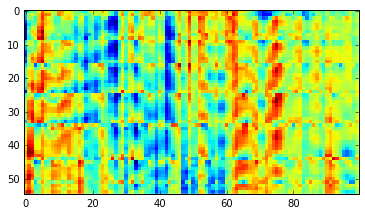

0.0117251351476
0


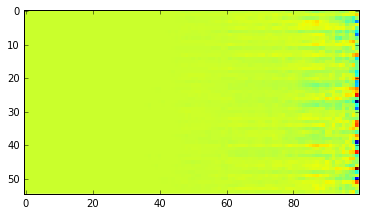

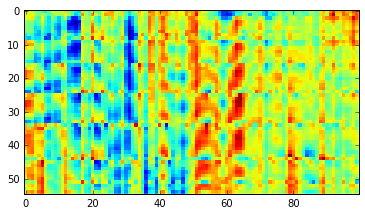

0.0102465115488
0


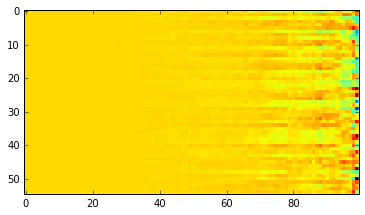

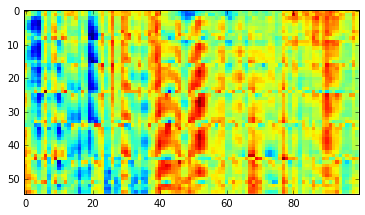

0.0136219114065
0


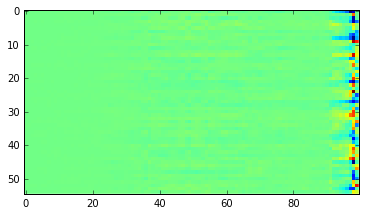

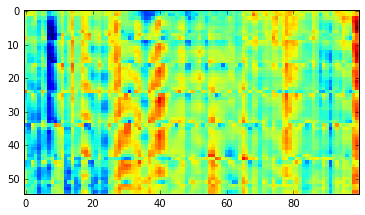

0.0131691610441
0


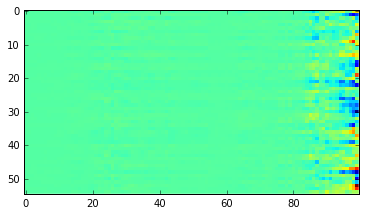

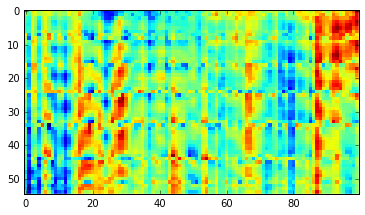

0.0113442130387
0


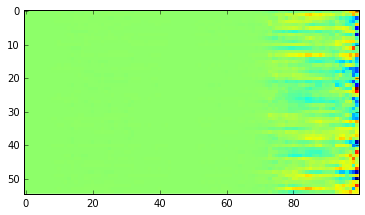

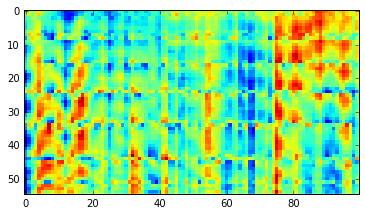

0.0121271591634
0


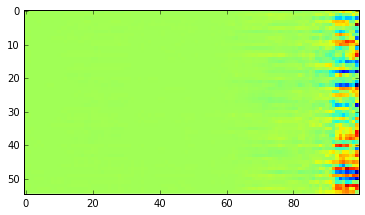

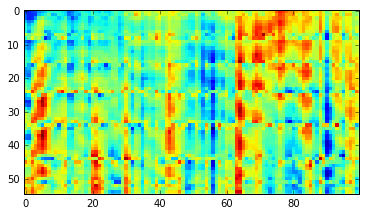

0.0206610895693
0


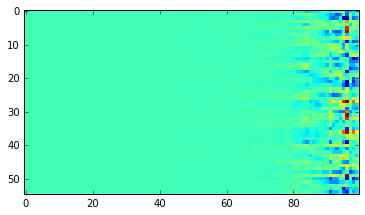

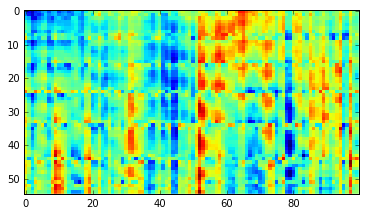

In [67]:
%matplotlib inline

for sample_i in range(100):
    print test_prediction[sample_i,1 ]
    print test_target_gcd[sample_i]
    data_to_diagnots =  stats.zscore(test_data_gcd, axis=1).astype('float32')[sample_i].reshape(1,100,55)
    
    temp = dlogistic(data_to_diagnots)
    temp.shape
    plt.imshow(temp[0,:,:].T, interpolation='none')
    plt.show()
    plt.imshow(data_to_diagnots[0,:,:].T, interpolation='none')
    plt.show()




In [41]:
model.layers[-1].get_output(train=False)[0]

# >>> x = T.dmatrix('x')
# >>> s = T.sum(1 / (1 + T.exp(-x)))
# >>> gs = T.grad(s, x)

Subtensor{int64}.0

In [43]:
result_func[0,:]

TypeError: unhashable type

In [57]:

x = T.dmatrix('x')
y = T.dmatrix('y')
z = x + y
f = theano.function([x, y], z[:,0])

In [58]:
f(np.asarray([[1,2]]), np.asarray([[1,2]]))

array([ 2.])

In [66]:
 T.grad(z[:,0],x)

TypeError: cost must be a scalar.

In [127]:
np.where(test_prediction[:,1 ] > 0.12)


(array([   38,    74,    75,    76,   103,   104,   178,   183,   187,
          188,   256,   276,   277,   339,   358,   359,   370,   371,
          396,   425,   451,   477,   530,   566,   589,   590,   646,
          653,   692,   693,   694,   747,   770,   771,   789,   790,
          845,   846,   847,   888,   911,   912,   913,   956,   957,
          958,  1020,  1047,  1064,  1068,  1166,  1188,  1276,  1286,
         1357,  1360,  1362,  1407,  1426,  1494,  1495,  1551,  1603,
         1671,  1738,  1765,  1816,  1817,  1827,  1828,  1829,  1857,
         1858,  1924,  1925,  1926,  1927,  1947,  1948,  1997,  1998,
         2020,  2051,  2111,  2112,  2150,  2151,  2168,  2169,  2234,
         2235,  2236,  2269,  2270,  2271,  2305,  2307,  2318,  2360,
         2440,  2441,  2442,  2443,  2491,  2492,  2525,  2526,  2527,
         2566,  2587,  2612,  2680,  2715,  2716,  2758,  2784,  2785,
         2793,  2794,  2847,  2848,  2875,  2920,  2997,  3057,  3058,
      

In [106]:
np.where(test_target_gcd == 1)

(array([    4,    39,    74,   104,   149,   159,   194,   214,   264,
          284,   316,   341,   371,   396,   431,   476,   486,   526,
          566,   596,   608,   658,   678,   693,   723,   753,   788,
          823,   848,   893,   912,   957,   982,   992,  1047,  1057,
         1092,  1127,  1167,  1187,  1220,  1255,  1275,  1305,  1335,
         1365,  1395,  1425,  1460,  1495,  1524,  1534,  1579,  1604,
         1624,  1679,  1709,  1724,  1754,  1789,  1801,  1841,  1876,
         1901,  1946,  1966,  1986,  2016,  2051,  2096,  2110,  2150,
         2165,  2200,  2235,  2270,  2305,  2330,  2365,  2395,  2402,
         2442,  2472,  2492,  2527,  2567,  2607,  2612,  2657,  2692,
         2718,  2758,  2788,  2808,  2838,  2868,  2893,  2928,  2963,
         2988,  3010,  3055,  3060,  3095,  3130,  3165,  3195,  3215,
         3250,  3285,  3308,  3353,  3363,  3393,  3423,  3478,  3498,
         3538,  3568,  3578,  3617,  3647,  3682,  3702,  3722,  3767,
      

In [131]:
test_data_gcd.shape, test_target_gcd.shape


((13800L, 40L, 55L), (13800L,))

In [132]:
# result_func = theano.function([model.get_input(train=False)], model.layers[-1].get_output(train=False)[:,0])
model.layers

In [133]:
precalssify_layer = theano.function([model.get_input(train=False)], model.layers[0].get_output(train=False))

In [141]:
middle_layer_test_data = precalssify_layer(stats.zscore(test_data_gcd, axis=1).astype('float32'))

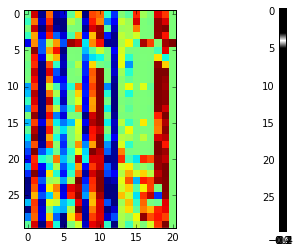

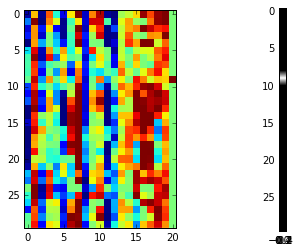

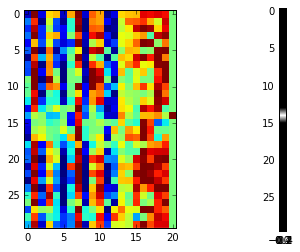

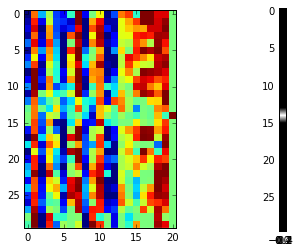

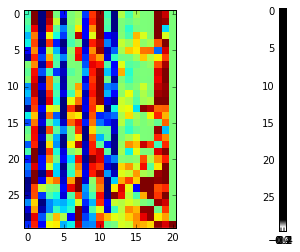

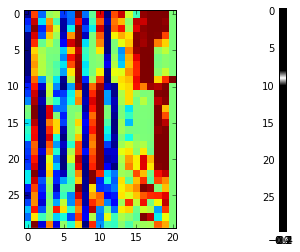

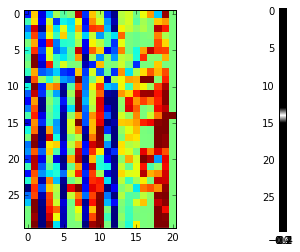

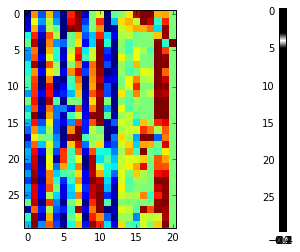

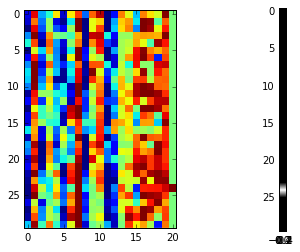

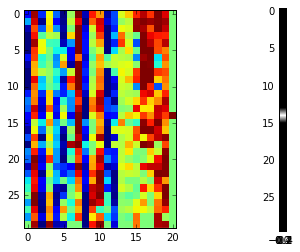

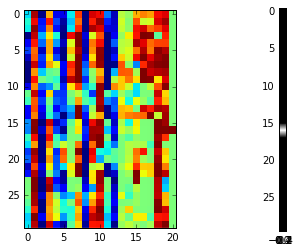

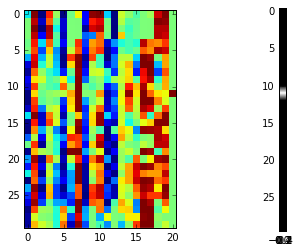

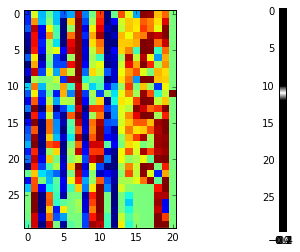

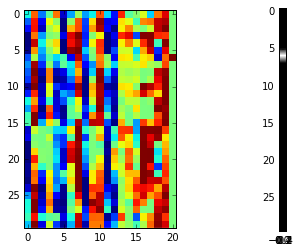

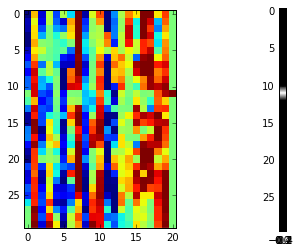

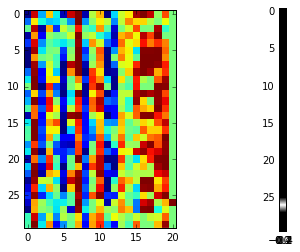

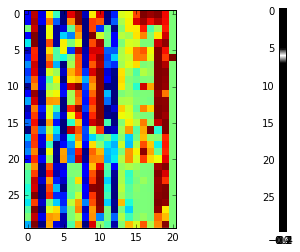

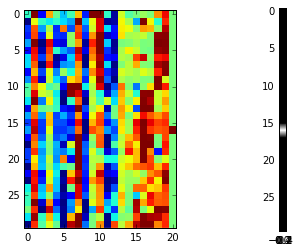

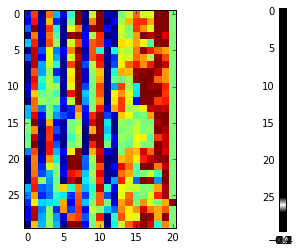

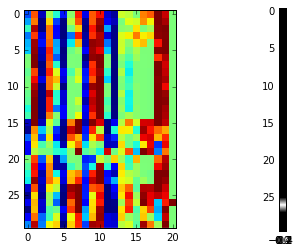

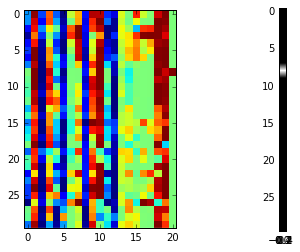

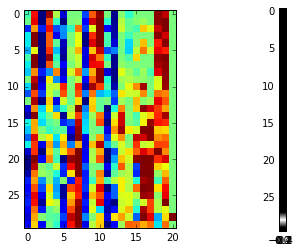

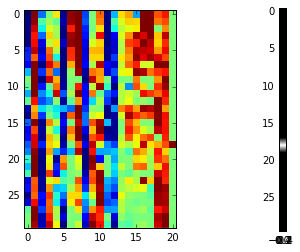

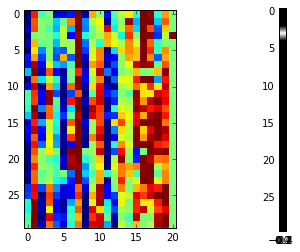

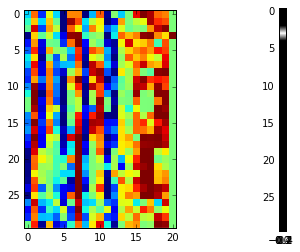

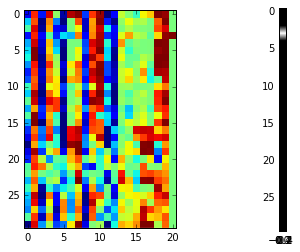

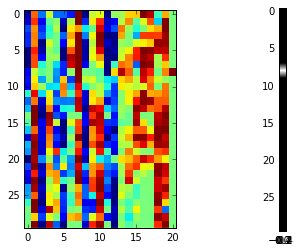

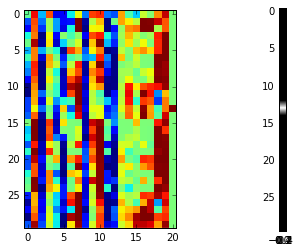

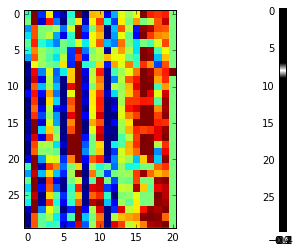

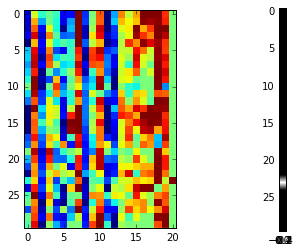

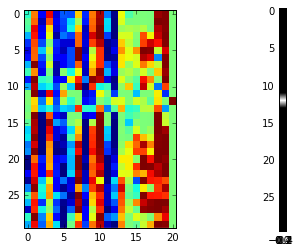

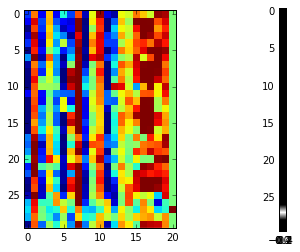

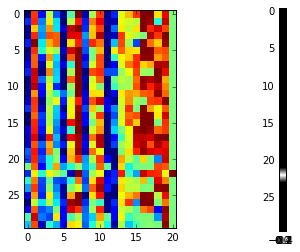

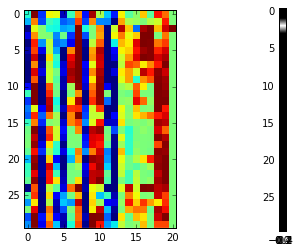

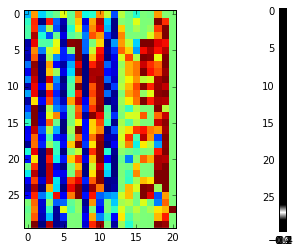

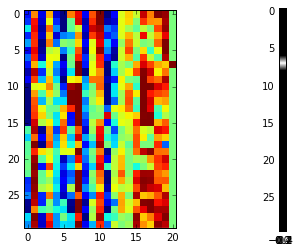

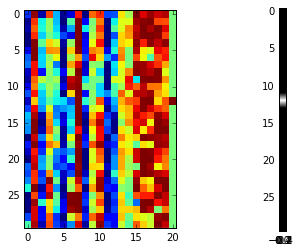

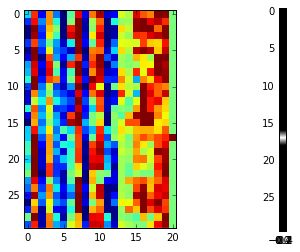

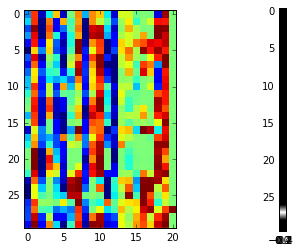

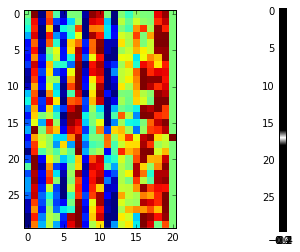

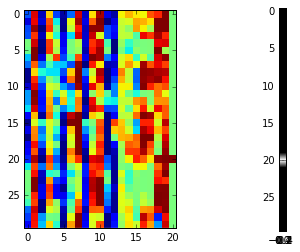

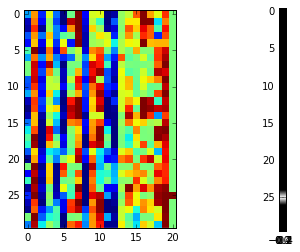

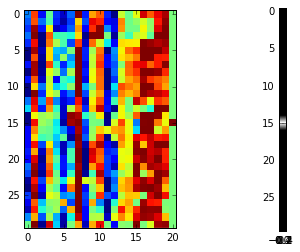

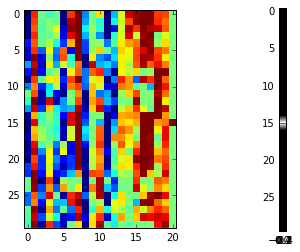

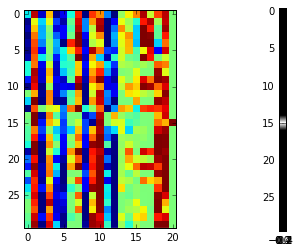

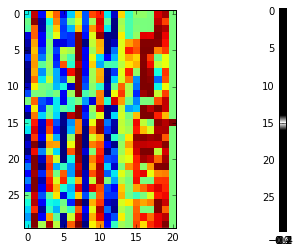

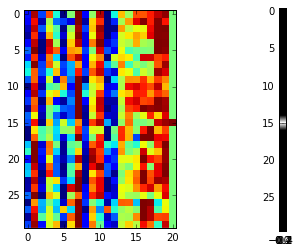

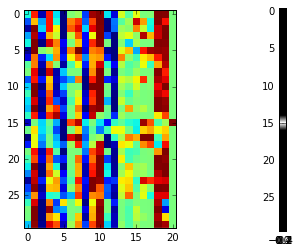

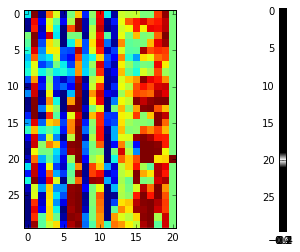

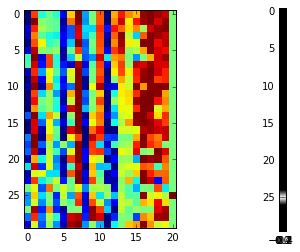

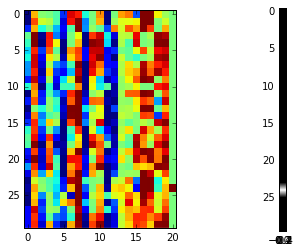

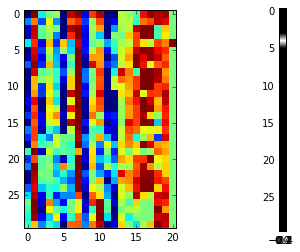

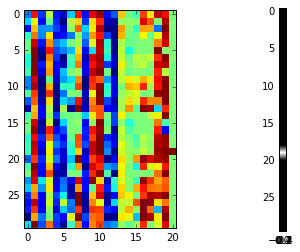

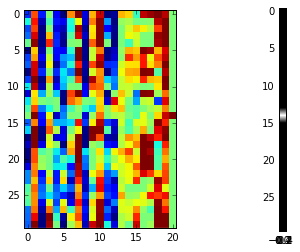

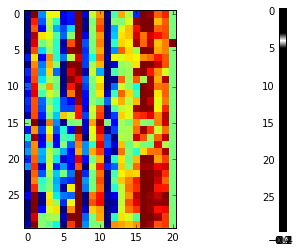

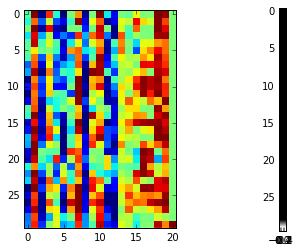

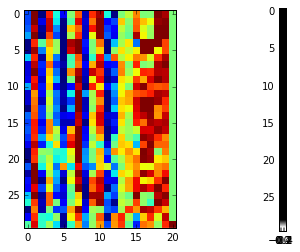

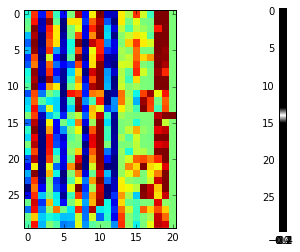

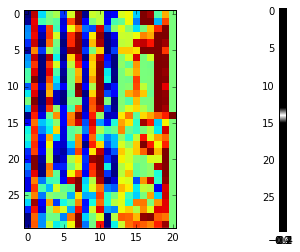

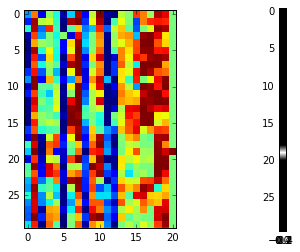

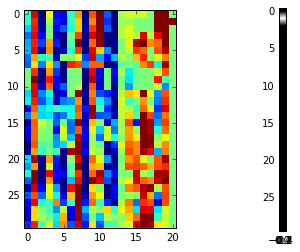

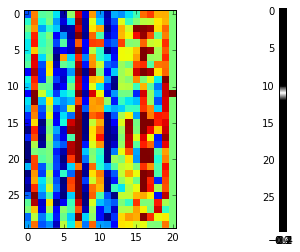

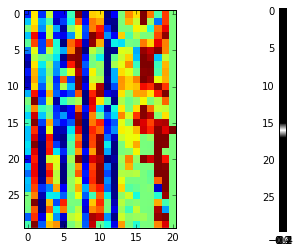

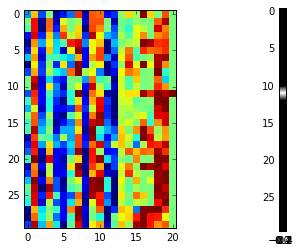

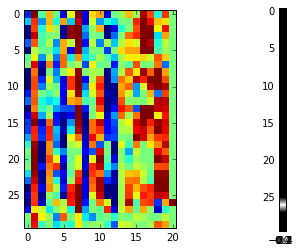

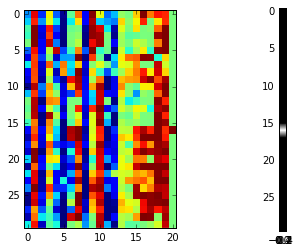

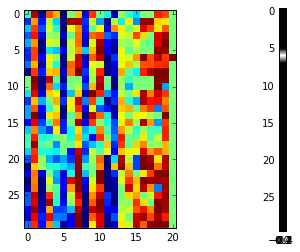

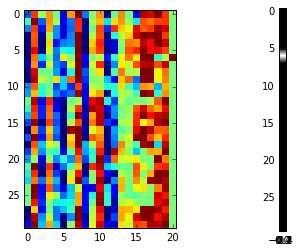

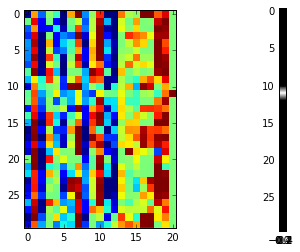

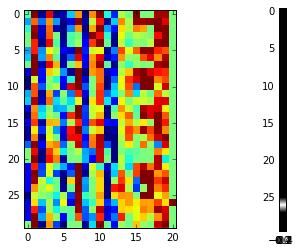

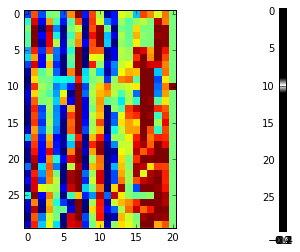

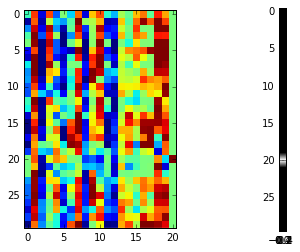

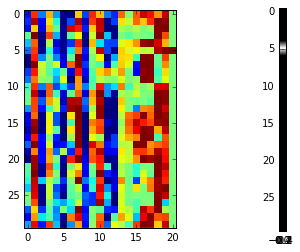

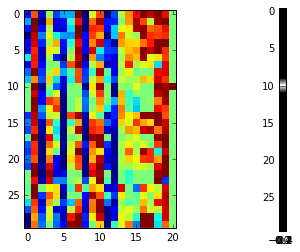

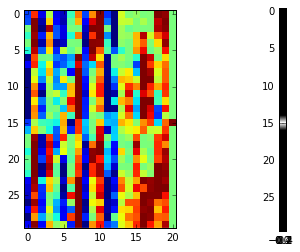

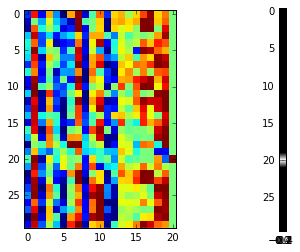

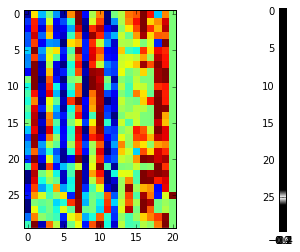

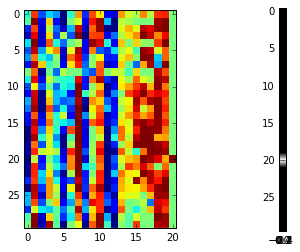

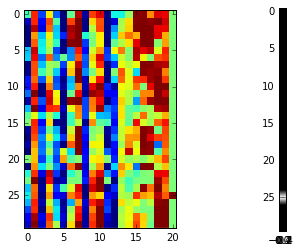

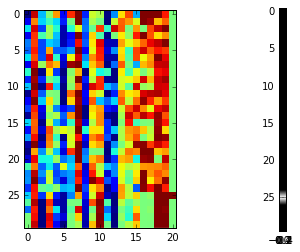

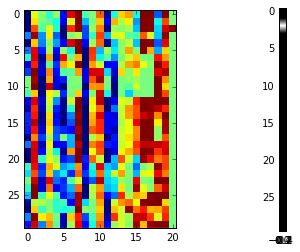

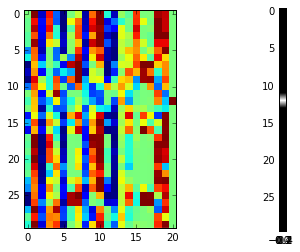

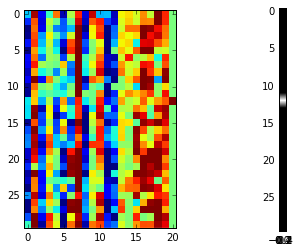

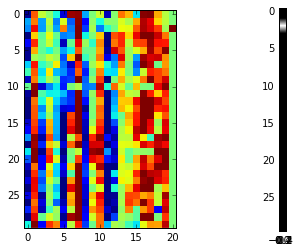

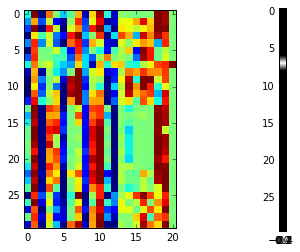

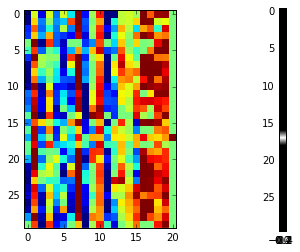

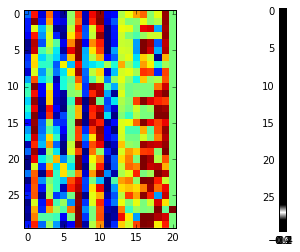

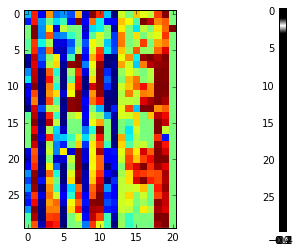

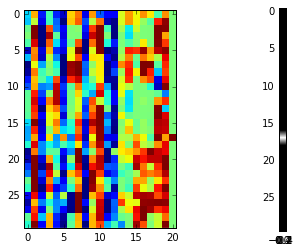

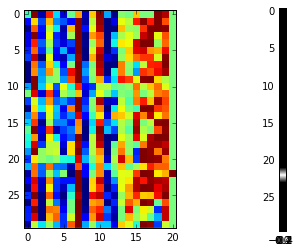

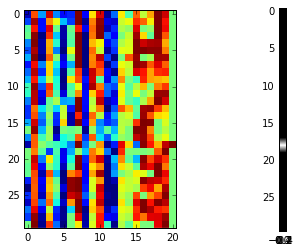

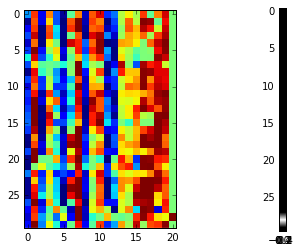

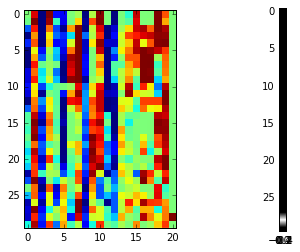

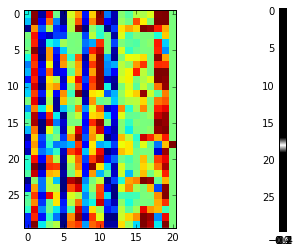

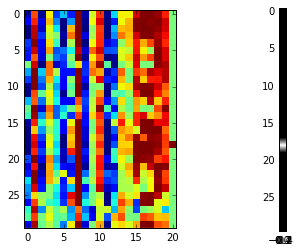

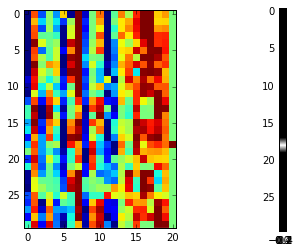

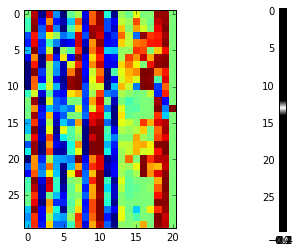

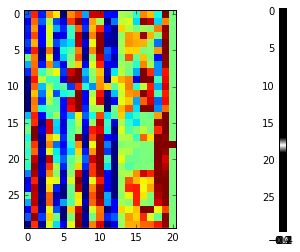

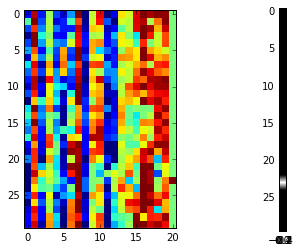

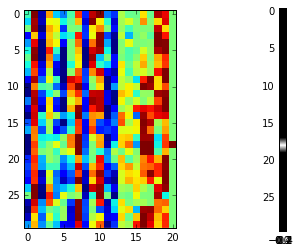

In [168]:
import matplotlib.cm as cm
for i in range(100):
    plt.subplot(1,2,1)
    plt.imshow(np.hstack([middle_layer_test_data[i*30:(i+1)*30,:], test_target_gcd.reshape(test_target_gcd.shape[0],1)[i*30:(i+1)*30]]) ,interpolation='none')
    plt.subplot(1,2,2)
#     print test_target_gcd.reshape(test_target_gcd.shape[0],1)
    plt.imshow(test_target_gcd.reshape(test_target_gcd.shape[0],1)[i*30:(i+1)*30],cmap = cm.Greys_r)
    plt.show()
#     plt.subplot(1,2,1)
#     plt.imshow(middle_layer_test_data[30:60,:],interpolation='none')
#     plt.subplot(1,2,2)
#     plt.imshow(test_target_gcd.reshape(test_target_gcd.shape[0],1)[30:60], cmap = cm.Greys_r)
#     plt.show()
#     reshaped_middle_layer_test_data = middle_layer_test_data.reshape(30,-1)
#     reshaped_middle_layer_test_data.shape

In [152]:
9200/20

460

In [179]:
from sklearn.decomposition import PCA
from sklearn.lda import LDA

C:\Anaconda\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


(13800L, 1L)


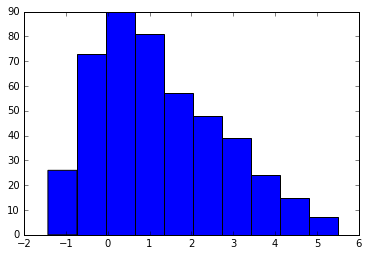

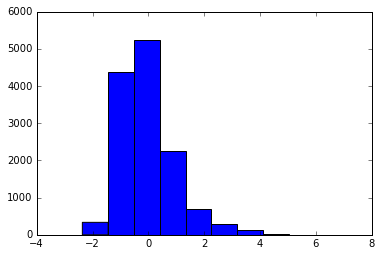

In [185]:
clf = LDA()
lda_res = clf.fit_transform(middle_layer_test_data, test_target_gcd)
print lda_res.shape
plt.hist(lda_res[test_target_gcd == 1])
plt.show()
plt.hist(lda_res[test_target_gcd == 0])
plt.show()


# pca = PCA(n_components=3)
# temp = pca.fit_transform(middle_layer_test_data)

In [176]:
temp.shape

(13800L, 3L)

AttributeError: Unknown property m

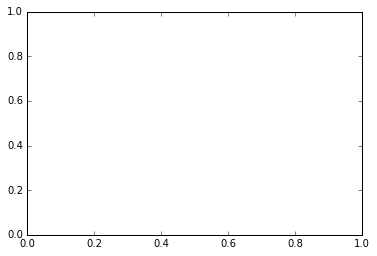

In [178]:
plt.scatter(temp[:,0], temp[:,1], temp[:,2], c=test_target_gcd)